In [2]:
import pandas as pd #для анализа и предобработки данных
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing  import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder #для кодирования признаков
from sklearn import linear_model #линейные модели
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from  sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

In [3]:
data = pd.read_excel('data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         7017 non-null   int64  
 1   year          7017 non-null   int64  
 2   condition     7017 non-null   int64  
 3   cylinders     7017 non-null   int64  
 4   odometer      7017 non-null   int64  
 5   title_status  7017 non-null   object 
 6   transmission  7017 non-null   object 
 7   drive         6626 non-null   object 
 8   size          5453 non-null   object 
 9   lat           7017 non-null   float64
 10  long          7017 non-null   float64
 11  weather       6837 non-null   float64
dtypes: float64(3), int64(5), object(4)
memory usage: 658.0+ KB


<AxesSubplot: >

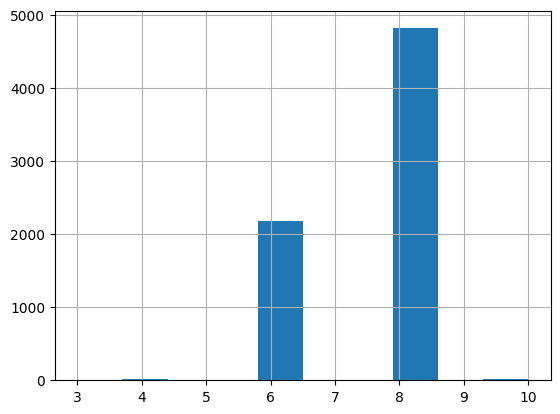

In [5]:
data['cylinders'].hist()

<AxesSubplot: >

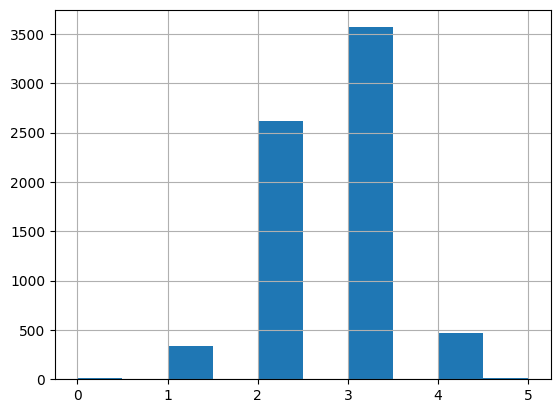

In [6]:
data['condition'].hist()

In [7]:
data['title_status'].value_counts()

clean      6657
rebuilt     151
lien        144
salvage      59
missing       6
Name: title_status, dtype: int64

In [8]:
data['lat'].describe()

count    7017.000000
mean       39.550144
std         5.745409
min        -2.508807
25%        35.661076
50%        40.335245
75%        43.582100
max        77.617682
Name: lat, dtype: float64

In [9]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
 
for column in columns_to_change:
 print('Число уникальных значений признака {}: '.format(column), data[column].nunique())

Число уникальных значений признака cylinders:  6
Число уникальных значений признака title_status:  5
Число уникальных значений признака transmission:  3
Число уникальных значений признака drive:  3
Число уникальных значений признака size:  4


In [10]:
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(data[columns_to_change]).toarray()
 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
print(column_names)

['cylinders_3' 'cylinders_4' 'cylinders_5' 'cylinders_6' 'cylinders_8'
 'cylinders_10' 'title_status_clean' 'title_status_lien'
 'title_status_missing' 'title_status_rebuilt' 'title_status_salvage'
 'transmission_automatic' 'transmission_manual' 'transmission_other'
 'drive_4wd' 'drive_fwd' 'drive_rwd' 'drive_nan' 'size_compact'
 'size_full-size' 'size_mid-size' 'size_sub-compact' 'size_nan']


In [11]:
data_onehot = pd.DataFrame(data_onehot, index=data.index, columns=column_names)
data_new = pd.concat([data, data_onehot], axis=1)
data_new = data_new.drop(columns=columns_to_change)
print(data_new.shape)

(7017, 30)


In [12]:
data.isnull().sum()

price              0
year               0
condition          0
cylinders          0
odometer           0
title_status       0
transmission       0
drive            391
size            1564
lat                0
long               0
weather          180
dtype: int64

In [13]:
data[~data['weather'].isna()]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
5,6995,2003,3,8,167662,clean,automatic,4wd,full-size,45.518031,-122.578752,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


In [14]:
data[~data['size'].isna()]

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
5,6995,2003,3,8,167662,clean,automatic,4wd,full-size,45.518031,-122.578752,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7012,22500,2015,3,6,23500,clean,automatic,rwd,full-size,32.680700,-117.169800,59.0
7013,5975,2005,2,8,0,clean,automatic,rwd,full-size,38.213303,-85.785762,50.0
7014,9999,2006,3,8,161514,clean,automatic,NaN,full-size,37.609783,-120.995406,59.0
7015,10900,2011,2,8,164000,clean,automatic,4wd,full-size,43.140600,-93.385000,47.0


In [15]:
np.round(len(data[~data['size'].isna()])/len(data),2)

0.78

In [16]:
y = data['price']
x = data.drop(columns='price')

In [17]:
x = x.dropna()
y = y.iloc[x.index]

In [18]:
x.shape[0]==y.shape[0]

True

**Кодирование признаков**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [20]:
def encode_cat_features(columns_to_change, X_train, X_test, y_train):
  one_hot_encoder = OneHotEncoder()
  X_train_onehot = one_hot_encoder.fit_transform(X_train[columns_to_change]).toarray()
  X_test_onehot = one_hot_encoder.transform(X_test[columns_to_change]).toarray()

  columns = one_hot_encoder.get_feature_names_out(columns_to_change)
  
  X_train_onehot_df = pd.DataFrame(X_train_onehot, columns=columns)
  X_test_onehot_df = pd.DataFrame(X_test_onehot, columns=columns)

  X_train = X_train.reset_index().drop(['index'], axis = 1)
  X_test = X_test.reset_index().drop(['index'], axis = 1)
  y_train = y_train.reset_index().drop(['index'], axis = 1)

  X_train_new = pd.concat([X_train, X_train_onehot_df], axis=1)
  X_test_new = pd.concat([X_test, X_test_onehot_df], axis=1)
  
  X_train_new = X_train_new.drop(columns=columns_to_change)
  X_test_new = X_test_new.drop(columns=columns_to_change)

  return X_train_new, X_test_new

In [21]:
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

**Работа с пропусками**

**Обучение модели без заполнения пустых значений**

In [22]:
#создаем и обучаем модель
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_new, y_train)

#Делаем предсказания и изучаем метрики
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.647
Test R^2: 0.693


**Обучение модели с заполнением пустых значений**

In [23]:
y = data['price']
x = data.drop(columns='price')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [25]:
#Заполним числовой столбец средним значением
X_train['weather'] = X_train['weather'].fillna(np.round(np.mean(X_train['weather']),0))
X_test['weather'] = X_test['weather'].fillna(np.round(np.mean(X_train['weather']),0))
#воспользуемся заполнением наиболее частым значением категориальных признаков
X_train['drive'].value_counts(True).head(1)
X_train['size'].value_counts(True).head(1)

X_train['size'] = X_train['size'].fillna('full-size')
X_train['drive'] = X_train['drive'].fillna('4wd')
 
X_test['size'] = X_test['size'].fillna('full-size')
X_test['drive'] = X_test['drive'].fillna('4wd')

In [26]:
X_train_new, X_test_new = encode_cat_features(columns_to_change, X_train, X_test, y_train)

In [27]:
#создаем и обучаем модель
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_new, y_train)

#Делаем предсказания и изучаем метрики
y_train_predict = lr_model.predict(X_train_new)
y_test_predict = lr_model.predict(X_test_new)
print("Train R^2: {:.3f}".format(r2_score(y_train, y_train_predict)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_test_predict)))

Train R^2: 0.649
Test R^2: 0.465


**Использование модели для прогнозирования пропущенных значений**

In [28]:
#используем модель для прогнозирования пропусков в признаке weather
data = x.copy()

#отделяем данные, имеющие пропуски, от данных, не имещих пропуски
test_data = data[data['weather'].isnull()]
data.dropna(inplace=True)

#заносим признак в переменную y, удаляем колонки, имеющие пропуски
y_train = data['weather']
X_train = data.drop(['size','weather','drive'], axis=1)
X_test = test_data.drop(['size','weather','drive'], axis=1)

#кодируем категориальные признаки
categorial_cols = ['cylinders', 'title_status', 'transmission']
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [29]:
#строим модель и делаем предсказания
model = linear_model.LinearRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)
y_pred

array([ 40.91435555,  40.7637233 ,  39.74866152,  41.2755305 ,
        40.31791932,  41.10796547,  41.15337846,  39.94866488,
        41.10796547,  40.7217165 ,  40.18904454,  91.62094167,
        41.12549856,  41.33052316,  39.66827354,  40.91435555,
        40.77287826,  40.84208674,  41.10796547,  41.02118034,
        40.31791932,  41.30309209,  40.77645269,  40.75842615,
        40.61605044,  40.79031628,  40.7701239 ,  39.78723017,
        41.27231621,  39.77492057,  40.7637233 ,  40.7701239 ,
        41.10796547,  39.68313064,  40.12277414,  39.7873657 ,
        41.07798631,  41.06812063,  40.7637233 ,  40.90194049,
        41.10796547,  70.85737739,  30.44339508,  40.76125291,
        39.77492057,  41.12549856,  39.74864816,  40.72219488,
        40.97162064,  40.7448585 ,  39.71065847,  39.78779447,
        39.77492057,  40.15945849,  41.12549856,  40.7902779 ,
        39.65555168,  41.10796547,  40.76125291,  40.15619215,
        40.79031628,  41.10796547,  40.7902779 ,  40.72

In [30]:
#добавляем полученные значения на место пропусков
for i, ni in enumerate(test_data.index[:len(x)]):
             x['weather'].loc[ni] = y_pred[i]

C:\Users\sergi\AppData\Local\Temp\ipykernel_7580\4288803648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['weather'].loc[ni] = y_pred[i]


In [31]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          5453 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


In [32]:
#используем модель для прогнозирования пропусков в признаке size
data = x.copy()

#отделяем данные, имеющие пропуски, от данных, не имещих пропуски
test_data = data[data['size'].isnull()]
data.dropna(inplace=True)

#заносим признак в переменную y, удаляем колонки, имеющие пропуски
y_train = data['size']
X_train = data.drop(['size', 'drive'], axis=1)
X_test = test_data.drop(['size','drive'], axis=1)

#кодируем категориальные признаки
X_train_new, X_test_new = encode_cat_features(categorial_cols, X_train, X_test, y_train)

In [33]:
model = linear_model.LogisticRegression()
model.fit(X_train_new, y_train)
 
y_pred = model.predict(X_test_new)
y_pred

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['full-size', 'full-size', 'full-size', ..., 'full-size',
       'full-size', 'full-size'], dtype=object)

In [34]:
for i, ni in enumerate(test_data.index[:len(x)]):
             x['size'].loc[ni] = y_pred[i]

C:\Users\sergi\AppData\Local\Temp\ipykernel_7580\2553570009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['size'].loc[ni] = y_pred[i]


In [35]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7017 entries, 0 to 7016
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          7017 non-null   int64  
 1   condition     7017 non-null   int64  
 2   cylinders     7017 non-null   int64  
 3   odometer      7017 non-null   int64  
 4   title_status  7017 non-null   object 
 5   transmission  7017 non-null   object 
 6   drive         6626 non-null   object 
 7   size          7017 non-null   object 
 8   lat           7017 non-null   float64
 9   long          7017 non-null   float64
 10  weather       7017 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 603.1+ KB


**РАБОТА С ВЫБРОСАМИ**

In [36]:
#Cформируем baseline-модель. 
#Проведём следующую предобработку: для простоты уберём категориальные столбцы из данных и затем удалим строки с пропусками.
data = pd.read_excel('data/data_ford_price.xlsx')

data = data[['price', 'year', 'cylinders', 'odometer' ,'lat', 'long','weather']]
data.dropna(inplace = True)

y = data['price']
x = data.drop(columns='price')
x.head()

,year,cylinders,odometer,lat,long,weather
0,2016,6,43500,36.471500,-82.483400,59.0
1,2009,8,98131,40.468826,-74.281734,52.0
2,2002,8,201803,42.477134,-82.949564,45.0
3,2000,8,170305,40.764373,-82.349503,49.0
5,2003,8,167662,45.518031,-122.578752,50.0


In [37]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 4682.957


**Использование IsolationForest для поиска выбросов**

In [38]:
# ищем выбросы в обучающей выборке
iso = IsolationForest(contamination=0.1)
y_predicted = iso.fit_predict(X_train)
 
# выберем все строки, которые не являются выбросами
mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


(4306, 6) (4306,)
MAE: 4429.514


**Использование Local Outlier Factor для поиска выбросов**

In [39]:
lof = LocalOutlierFactor()
y_predicted = lof.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3951, 6) (3951,)
MAE: 4439.129


**Использование Minimum Covariance Determinant для поиска выбросов**

In [40]:
ee = EllipticEnvelope(contamination=0.01)
y_predicted = ee.fit_predict(X_train)

mask = y_predicted != -1
X_train, y_train = X_train[mask], y_train[mask]
 
print(X_train.shape, y_train.shape)
 
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
 
y_predicted = model.predict(X_test)
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

(3911, 6) (3911,)
MAE: 4443.810


**Масштабирование признаков**

**Standard Scaler**

In [41]:
data = pd.read_excel('data/data_ford_price.xlsx')

data = data[['price', 'year', 'weather']]
data.dropna(inplace = True)

data_scaled = data.copy()
col_names = ['price', 'weather']
x = data_scaled[col_names]

scaler = StandardScaler()
 
data_scaled[col_names] = scaler.fit_transform(x.values)
data_scaled

,price,year,weather
0,2.558728,2016,0.862068
1,0.067373,2009,-0.017965
2,-1.072197,2002,-0.897998
3,-1.176990,2000,-0.395122
5,-0.677579,2003,-0.269403
...,...,...,...
7012,0.682100,2015,0.862068
7013,-0.767025,2005,-0.269403
7014,-0.414149,2006,0.862068
7015,-0.335138,2011,-0.646560


In [42]:
y = data_scaled['year']
x = data_scaled.drop(columns='year')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [43]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 3.041


**MinMax Scaler**

In [44]:
data = pd.read_excel('data/data_ford_price.xlsx')

data = data[['price', 'year', 'weather']]
data.dropna(inplace = True)

data_scaled = data.copy()
col_names = ['price', 'weather']
x = data_scaled[col_names]

scaler = MinMaxScaler()
 
data_scaled[col_names] = scaler.fit_transform(x.values)
data_scaled

,price,year,weather
0,0.146575,2016,0.714286
1,0.051716,2009,0.547619
2,0.008327,2002,0.380952
3,0.004337,2000,0.476190
5,0.023352,2003,0.500000
...,...,...,...
7012,0.075122,2015,0.714286
7013,0.019947,2005,0.500000
7014,0.033382,2006,0.714286
7015,0.036391,2011,0.428571


In [45]:
y = data_scaled['year']
x = data_scaled.drop(columns='year')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [46]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 3.041


**Robust Scaler**

In [47]:
data = pd.read_excel('data/data_ford_price.xlsx')

data = data[['price', 'year', 'weather']]
data.dropna(inplace = True)

data_scaled = data.copy()
col_names = ['price', 'weather']
x = data_scaled[col_names]

scaler = RobustScaler()
 
data_scaled[col_names] = scaler.fit_transform(x.values)
data_scaled

,price,year,weather
0,1.982455,2016,0.571429
1,0.189460,2009,0.071429
2,-0.630672,2002,-0.428571
3,-0.706090,2000,-0.142857
5,-0.346671,2003,-0.071429
...,...,...,...
7012,0.631871,2015,0.571429
7013,-0.411044,2005,-0.071429
7014,-0.157084,2006,0.571429
7015,-0.100221,2011,-0.285714


In [48]:
y = data_scaled['year']
x = data_scaled.drop(columns='year')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=40)

In [60]:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)
 
mae = mean_absolute_error(y_test, y_predicted)
print('MAE: %.3f' % mae)

MAE: 3.041


**Трансформации распределений признаков**

**QUANTILE TRANSFORMER**

In [52]:
data = pd.read_excel('data/data_ford_price.xlsx')
data.head()

,price,year,condition,cylinders,odometer,title_status,transmission,drive,size,lat,long,weather
0,43900,2016,4,6,43500,clean,automatic,4wd,full-size,36.471500,-82.483400,59.0
1,15490,2009,2,8,98131,clean,automatic,4wd,full-size,40.468826,-74.281734,52.0
2,2495,2002,2,8,201803,clean,automatic,4wd,full-size,42.477134,-82.949564,45.0
3,1300,2000,1,8,170305,rebuilt,automatic,4wd,full-size,40.764373,-82.349503,49.0
4,13865,2010,3,8,166062,clean,automatic,4wd,NaN,49.210949,-123.114720,NaN


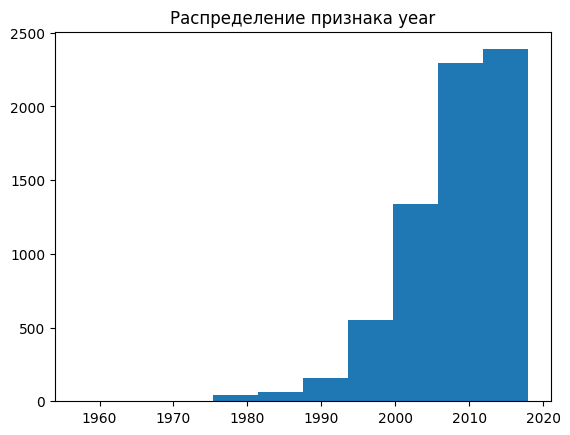

In [49]:
plt.hist(data.year)
plt.title('Распределение признака year');

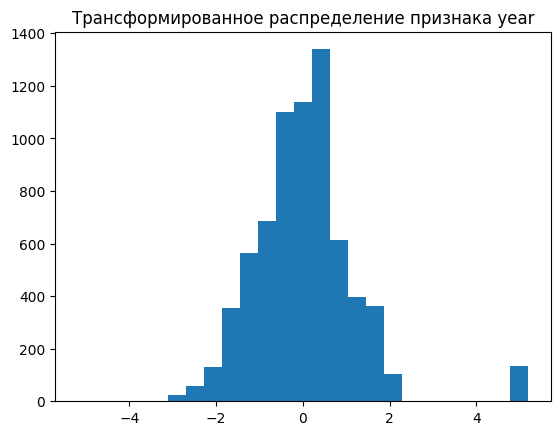

In [69]:
# Данный трансформер принимает на вход 2D-массив, поэтому нам надо изменить формат данных
data_for_transform = data['year'].values.reshape((len(data),1))
 
quantile = QuantileTransformer(output_distribution='normal')
data_transformed = quantile.fit_transform(data_for_transform)
 
plt.hist(data_transformed, bins=25)
plt.title('Трансформированное распределение признака year')
plt.show()

In [65]:
data_for_transform = data[['condition', 'cylinders']]
quantile = QuantileTransformer(output_distribution='uniform')
data_transformed = quantile.fit_transform(data_for_transform)
np.round(data_transformed[0][0],2)

0.96

**LOG TRANSFORM**

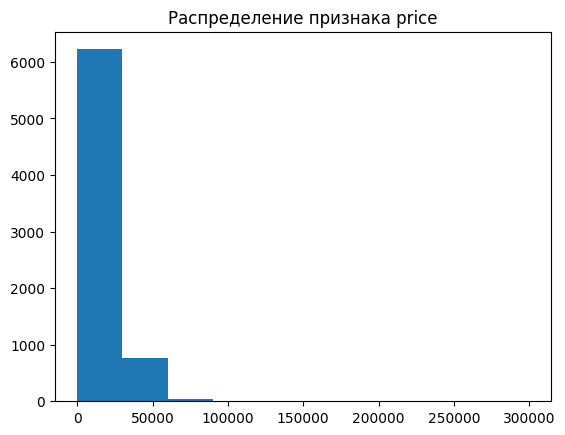

In [71]:
plt.hist(data.price)
plt.title('Распределение признака price');

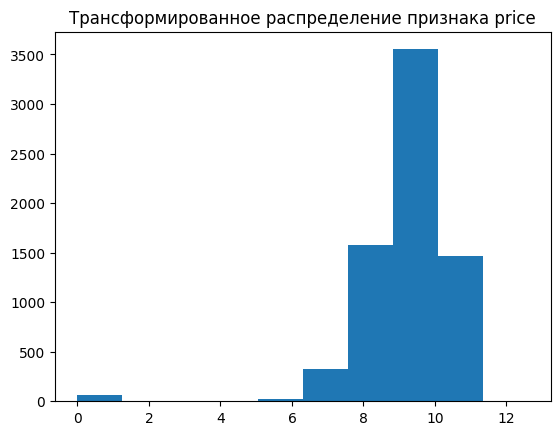

In [72]:
log_price = np.log(data['price'])
 
plt.hist(log_price)
plt.title('Трансформированное распределение признака price')
plt.show()

In [73]:
price_data = pd.concat([data['price'], log_price.rename('transformed_price')], axis = 1)
 
price_data.describe()

,price,transformed_price
count,7017.000000,7017.000000
mean,15121.549523,9.204510
std,11765.423119,1.275868
min,1.000000,0.000000
25%,5995.000000,8.698681
50%,12750.000000,9.453287
75%,21995.000000,9.998570
max,299500.000000,12.609870


**POWER TRANSFORMER SCALER**

In [85]:
box_cox = PowerTransformer(method = 'box-cox')
 
data_box_cox = box_cox.fit_transform(data[['price', 'year']].values)
data_box_cox = pd.DataFrame(data_box_cox, columns = ['transformed_price', 'transformed_year'])


c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


,transformed_price,transformed_year
0,1.910471,1.302970
1,0.270352,0.096260
2,-1.369721,-0.932327
3,-1.718754,-1.197200
4,0.132932,0.257090
...,...,...
7012,0.780988,1.118588
7013,-0.733027,-0.511569
7014,-0.238492,-0.364778
7015,-0.145148,0.421629


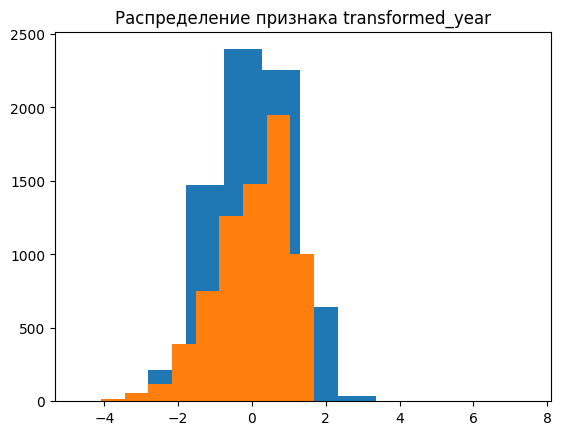

In [86]:
plt.hist(data_box_cox.transformed_price)
plt.title('Распределение признака transformed_price');
plt.hist(data_box_cox.transformed_year)
plt.title('Распределение признака transformed_year');